0.08125483171032237 0.10167332489098001
0.07647602684516216 0.113945388837763


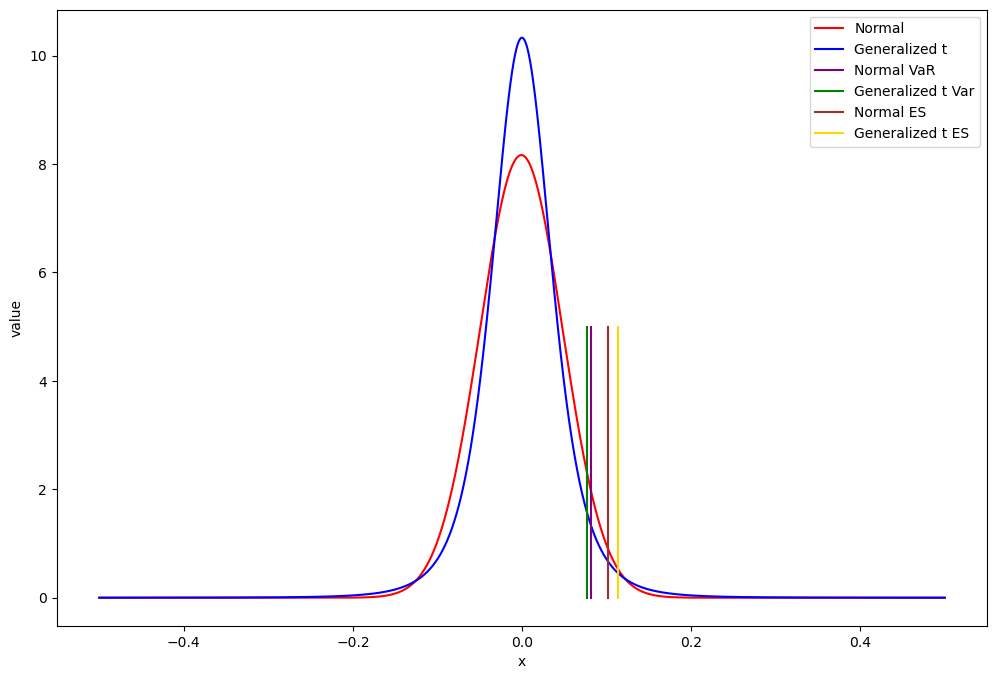

In [38]:
import numpy as np
from scipy.stats import norm,t
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from MRisk import Simulation,VaR_calculation

#problem 1
df=pd.read_csv('problem1.csv')
#normal
mu=np.mean(df['x'])
sd=np.std(df['x'])
alpha=0.05
VaR_Normal=-norm.ppf(alpha,mu,sd)
ES_Normal=-mu+sd*norm.pdf(norm.ppf(alpha,0,1))/alpha
print(VaR_Normal,ES_Normal)

#generalized t
dist=getattr(stats,'t')
params=dist.fit(df['x'])
VaR_t=-t.ppf(alpha,df=params[0],loc=params[1],scale=params[2])
sim=t.rvs(df=params[0],loc=params[1],scale=params[2],size=10000)
ES_t=-np.mean(sim[sim<=-VaR_t])
print(VaR_t,ES_t)
#make plots
vec=np.linspace(-0.5,0.5,10000)
pdf_Normal=norm.pdf(vec,mu,sd)
pdf_t=t.pdf(vec,df=params[0],loc=params[1],scale=params[2])

plt.figure(figsize=(12, 8))
plt.plot(vec,pdf_Normal,'r-',label='Normal')
plt.plot(vec,pdf_t,'b-',label='Generalized t')
plt.plot(np.array([VaR_Normal,VaR_Normal]),np.array([0,5]),linestyle='-',color='purple',label='Normal VaR')
plt.plot(np.array([VaR_t,VaR_t]),np.array([0,5]),linestyle='-',color='green',label='Generalized t Var')
plt.plot(np.array([ES_Normal,ES_Normal]),np.array([0,5]),linestyle='-',color='brown',label='Normal ES')
plt.plot(np.array([ES_t,ES_t]),np.array([0,5]),color='gold',label='Generalized t ES')
plt.xlabel('x')
plt.ylabel('value')
plt.legend()
plt.show()




In [43]:
#problem 3
def return_calculate(price,method):
    names=price.columns
    num=len(names)
    names_2=names[names!='Date']

    if num==len(names_2):
        print('No Date column in the price data')
    else:
        num=num-1

    pos=np.where(names!='Date')[0]
    row_num=price.shape[0]
    out=np.zeros([row_num-1,num])
    for i in range(num):
        temp=np.array(price.iloc[:,pos[i]])

        if method.upper()=='DISCRETE':
            out[:,i]=temp[1:]/temp[0:-1]-1
        elif method.upper()=='LOG':
            out[:,i]=np.log(temp[1:])-np.log(temp[0:-1])
        else:
            print('method must in Log or Discrete')

    out=pd.DataFrame(out)
    out.index=price.index[1:]
    out.columns=price.columns[pos]

    return out

price=pd.read_csv('DailyPrices.csv')
rt=return_calculate(price,method='Discrete')
dist=getattr(stats,'t')
asset_num=rt.shape[1]
date_num=rt.shape[0]
rt_cdf=np.zeros([date_num,asset_num])
params_ls=[]
for i in range(asset_num):
    params = dist.fit(rt.iloc[:,i])
    params_ls.append(params)
    rt_cdf[:,i]=t.cdf(rt.iloc[:,i],df=params[0],loc=params[1],scale=params[2])

nsim=100000
sim=Simulation.copula_simulation(rt_cdf,nsim)
rt_sim=np.zeros([nsim,asset_num])
for i in range(asset_num):
    params=params_ls[i]
    rt_sim[:,i]=t.ppf(sim[:,i],df=params[0],loc=params[1],scale=params[2])

pt=pd.read_csv('portfolio.csv')
ls=['A','B','C']
stock_names=rt.columns
VAR_portfolio=np.zeros(4)
ES_portfolio=np.zeros(4)
portfolio_val=np.zeros([nsim,4])
for i in range(4):
    if i<3:
        pos_temp = np.where(pt.iloc[:, 0] == ls[i])[0]
        stock_num = len(pos_temp)
        for j in range(stock_num):
            pos_temp_2 = np.where(pt.iloc[pos_temp[j], 1] == stock_names)[0][0]
            portfolio_val[:,i]+=rt_sim[:,pos_temp_2]*price.iloc[-1, pos_temp_2+1]*pt.iloc[pos_temp[j], 2]
    else:
        portfolio_val[:,3]=np.sum(portfolio_val[:,0:3],1)

    VAR_portfolio[i] = -np.percentile(portfolio_val[:, i], 5)
    temp = portfolio_val[:, i]
    ES_portfolio[i] = -np.mean(temp[temp <= np.percentile(temp, 5)])


out=pd.DataFrame([VAR_portfolio,ES_portfolio]).T
out.index=['A','B','C','total']
out.columns=['VAR','ES']
out

,VAR,ES
A,7912.999183,10390.104192
B,6610.114825,8698.126912
C,5602.386317,7397.651940
total,19869.422454,26093.146587
